# AutoETS

AutoETS (Auto Exponential Smoothing) is an automatic forecasting method that applies exponential smoothing to time series data with trend and seasonality.

**Key Ideas**  
- Automatically selects the best exponential smoothing model based on information criteria (AIC, AICC or BIC).
- Provides point, variance, quantile, interval and distribution forecasts.
- Can be used with different types of seasonality or no seasonality at all.
- sktime package: provide multiple probabilistic forecasting methods and possible to implement its own custom probabilistic forecaster.

**Model documentation**: 

- github: https://github.com/sktime/sktime
- AutoETS: https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.ets.AutoETS.html
- sktime notebook proba forecasting: https://github.com/sktime/sktime/blob/main/examples/01b_forecasting_proba.ipynb
- user guide: https://www.sktime.net/en/v0.19.2/examples/01b_forecasting_proba.html
- guide to build your own probabilistic forecaster: https://www.sktime.net/en/stable/developer_guide/add_estimators.html

**Requirements:**

!pip install sktime

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            }
}
```
![proba_forecast_v2](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v2.png?raw=true)

In [22]:
import os
import pandas as pd
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt

TEST_DATA_START_TIME = 90000

current_dir = Path.cwd()
PATH_DATA = current_dir.parent.parent.parent / 'data' / 'bird_feed_data.csv'

def local_test_data_generator(path_data=PATH_DATA, chunksize=1000, start_time=TEST_DATA_START_TIME):
    """
    Generate the local test data yielding one record (dict) at a time.

    :param path_data: path to .csv data file
    :param chunksize: Number of rows to read at a time (default is 1000).
    """
    prev_time = start_time
    for chunk in pd.read_csv(path_data, chunksize=chunksize):
        for k, row in chunk.iterrows():
            if k > 500:
                row['time'] = row['time'] / math.pi  # don't ask
                if row['time'] > prev_time:
                    prev_time = row['time']
                    yield row.to_dict()


def remote_test_data_generator(chunksize=1000, start_time=TEST_DATA_START_TIME):
    """
    Generate the remote test data yielding one record (dict) at a time.

    :param chunksize: Number of rows to read at a time (default is 1000).
    """
    url = 'https://raw.githubusercontent.com/microprediction/birdgame/refs/heads/main/data/bird_feed_data.csv'
    prev_time = start_time
    for chunk in pd.read_csv(url, chunksize=chunksize):
        for k, row in chunk.iterrows():
            if k > 500:
                row['time'] = row['time'] / math.pi  # don't ask
                if row['time'] > prev_time:
                    prev_time = row['time']
                    yield row.to_dict()

### Warm up example

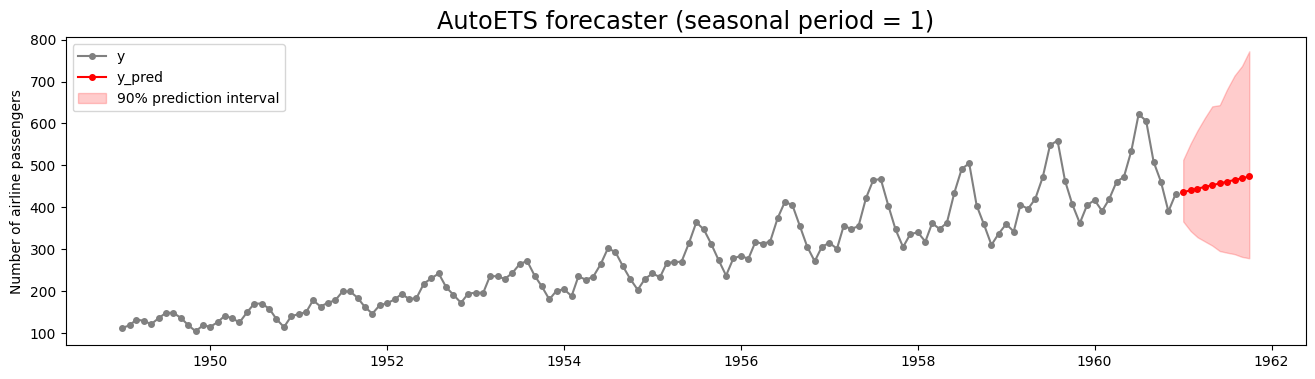

Variance estimation:


,Number of airline passengers
1961-01,2073.852194
1961-02,3884.384145
1961-03,6523.576313
1961-04,9277.248154
1961-05,10576.981375
1961-06,13142.749766
1961-07,13474.865495
1961-08,15728.136836
1961-09,16955.438857
1961-10,20112.174181


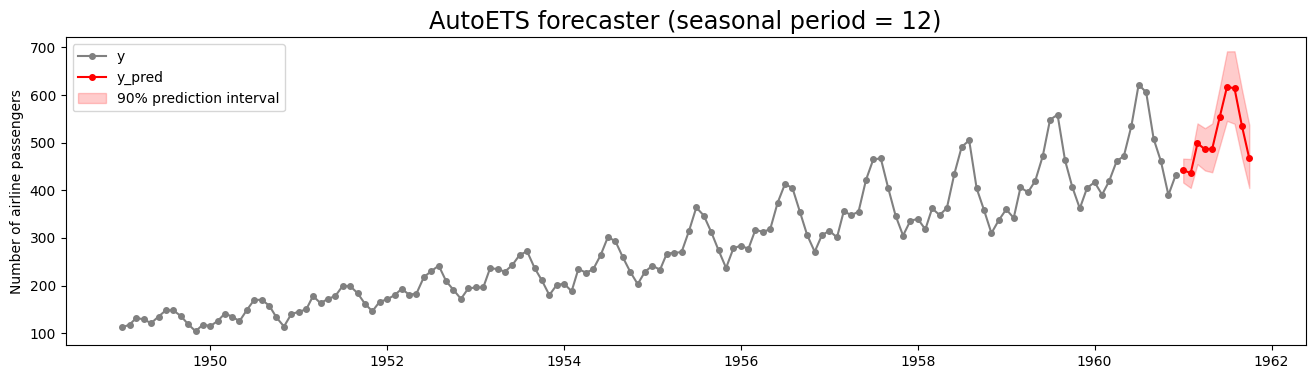

Variance estimation:


,Number of airline passengers
1961-01,227.643440
1961-02,348.870490
1961-03,658.990428
1961-04,728.527541
1961-05,927.485065
1961-06,1431.231389
1961-07,1915.189139
1961-08,2257.026380
1961-09,1910.394398
1961-10,1458.073849


In [23]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils import plotting
from sktime.datasets import load_airline

def visualize_sktime_model(seasonal_period=12):
    # Example dataset
    y = load_airline()

    # Forecasting horizon
    steps = 10  # Predict the next 10 steps
    fh = ForecastingHorizon(np.arange(1, steps + 1), is_relative=True)

    # Initialize and fit the AutoETS forecaster
    forecaster = AutoETS(auto=True, sp=seasonal_period, information_criterion="aic")
    forecaster.fit(y, fh=fh)

    # Make point forecast
    y_pred = forecaster.predict(fh=fh)

    # Make interval forecast
    coverage = 0.9
    y_pred_ints = forecaster.predict_interval(coverage=coverage)

    fig, ax = plotting.plot_series(
        y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints, 
        title=f"AutoETS forecaster (seasonal period = {seasonal_period})", colors=["grey", "red"]
    )
    ax.legend()
    plt.show()

    # Make Variance forecast
    print("Variance estimation:")
    y_pred_variance = forecaster.predict_var(fh=fh)
    display(y_pred_variance)

# Run AutoETS sktime model for different seasonal period
for sp in [1, 12]:
    visualize_sktime_model(seasonal_period=sp)

In [24]:
from birdgame.trackers.trackerbase import TrackerBase
import numpy as np
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sktime.forecasting.arima import AutoARIMA

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
    

class AutoETSsktimeTracker(TrackerBase):
    """
    A model that tracks the dove location using AutoETS.

    Parameters
    ----------
    horizon : int
        The "look-ahead" in time after which the recorded data becomes valid for updating.
    train_model_frequency : int
        The frequency at which the sktime model will be retrained based on the count of observations 
        ingested. This determines how often the model will be updated with new data.
    num_data_points_max : int
        The maximum number of data points to use for training the sktime model.
    """

    def __init__(self, horizon=10, train_model_frequency=100, num_data_points_max=20):
        super().__init__(horizon)
        self.current_x = None
        self.last_observed_data = [] # Holds the last few observed data points
        self.prev_t = 0

        self.train_model_frequency = train_model_frequency
        self.num_data_points_max = num_data_points_max

        # Number of steps to predict
        steps = 1 # only one because the univariate serie will only have values separated of at least HORIZON time
        self.fh = np.arange(1, steps + 1)

        # Fit the AutoETS forecaster (no seasonality)
        self.forecaster = AutoETS(auto=True, sp=1, information_criterion="aic")

        # or Fit the AutoARIMA forecaster
        # self.forecaster = AutoARIMA(max_p=2, max_d=1, max_q=2, maxiter=10)
        
    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the
        estimated Gaussian mixture model.

        The core distribution captures regular variance, while the tail distribution
        captures extreme deviations.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """
        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.current_x = x

        # we build a univariate serie of values separated of at least HORIZON time
        if t > self.prev_t + self.horizon:
            self.last_observed_data.append(x)
            self.prev_t = t

        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:

            if self.count > 10 and self.count%self.train_model_frequency == 0:
                # Construct 'y' as an univariate serie
                y = np.array(self.last_observed_data)[-self.num_data_points_max:]

                # Fit sktime model
                self.forecaster.fit(y, fh=self.fh)

                # Variance prediction
                var = self.forecaster.predict_var(fh=self.fh)
                self.scale = np.sqrt(var.values.flatten()[-1])

                # Update last observed data
                self.last_observed_data = self.last_observed_data[-(self.num_data_points_max + 2):]
            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a Gaussian distribution.
        """
        x_mean = self.current_x
        components = []

        try:
            # here we use current value as loc but you can get point forecast from 'self.forecaster.predict(fh=self.fh[-1])[0][0]'
            loc = x_mean

            # we predicted scale during tick training
            scale = self.scale
            scale = max(scale, 1e-6)

            # If you want to predict variance for each prediction
            # scale = self.forecaster.predict_var(fh=self.fh)
            # scale = np.sqrt(scale.values.flatten()[-1])
        except:
            loc = x_mean
            scale = 1e-6

        # Return the prediction density
        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale}
            },
            "weight": 1
        }

        prediction_density = {
            "type": "mixture",
            "components": [components]
        }

        return prediction_density

In [25]:
import typing


def train():
    pass


def infer(
    payload_stream: typing.Iterator[dict],
):
    # Parameters
    HORIZON = 10
    TRAIN_MODEL_FREQUENCY=50
    NUM_DATA_POINTS_MAX=20

    # Initialize Model
    model = AutoETSsktimeTracker(horizon=HORIZON, train_model_frequency=TRAIN_MODEL_FREQUENCY, 
                                 num_data_points_max=NUM_DATA_POINTS_MAX)

    yield  # Signal initialization completion

    for payload in payload_stream:
        model.tick(payload)
        yield model.predict()

In [26]:
def compute_pdf_score(past_pdf, observed_dove_location):
    """ Compute weighted PDF score of a normal distribution """
    weighted_pdf_score = 0
    highest_weight = 0
    stored_prediction = None

    for component in past_pdf.get('components', []):
        density = component['density']
        loc, scale, weight = density['params']['loc'], density['params']['scale'], component['weight']

        # Compute PDF score (Gaussian)
        pdf_score = (1 / (math.sqrt(2 * math.pi * scale**2))) * \
                    math.exp(-((observed_dove_location - loc) ** 2) / (2 * scale**2))

        weighted_pdf_score += weight * pdf_score

        # Store prediction with highest weight
        if weight > highest_weight:
            stored_prediction = (loc, scale, observed_dove_location, pdf_score)
            highest_weight = weight

    return round(weighted_pdf_score, 3), stored_prediction


def find_past_pdf(pdf_history, current_time, horizon):
    """ Function to find the most recent valid past prediction """
    for past_time, p_pdf in reversed(pdf_history):
        if past_time < current_time - horizon:
            return p_pdf
    return None  # No valid past prediction

In [27]:
import time
import json
from tqdm.auto import tqdm

# Parameters
HORIZON = 10
TRAIN_MODEL_FREQUENCY=50
NUM_DATA_POINTS_MAX=20
MAX_TRACKER_COUNT = 10000
SHOW_PRINT = True
STEP_PRINT = 1000

# Initialize Tracker
tracker = AutoETSsktimeTracker(horizon=HORIZON, train_model_frequency=TRAIN_MODEL_FREQUENCY, 
                               num_data_points_max=NUM_DATA_POINTS_MAX)

# History to track evaluation metrics and the PDFs
pdf_score_history = []
pdf_history = []
store_pred = []

# Start Processing Data
start_time = time.time()
if os.path.exists(PATH_DATA):
    data_generator = local_test_data_generator()
else:
    data_generator = remote_test_data_generator()

for payload in tqdm(data_generator, position=0, leave=True):
    try:
        tracker.tick(payload)
        pdf = tracker.predict()
        current_time = payload['time']

        # Store the latest PDF prediction
        pdf_history.append((current_time, pdf))

        # Find past PDF predicition for evaluation
        past_pdf = find_past_pdf(pdf_history, current_time, HORIZON)

        if past_pdf:
            observed_dove_location = payload['dove_location']
            weighted_pdf_score, prediction_info = compute_pdf_score(past_pdf, observed_dove_location)

            # Store results
            pdf_score_history.append(weighted_pdf_score)
            full_prediction_info = [current_time]
            full_prediction_info.extend(prediction_info)
            store_pred.append(full_prediction_info)

            if SHOW_PRINT and len(pdf_history) % STEP_PRINT == 0:
                print(
                    f"[{tracker.count}] PDF Score: {weighted_pdf_score:.4f} / true: {observed_dove_location:.4f} / "
                    f"pred: {prediction_info[0]:.4f} / dif: {observed_dove_location - prediction_info[0]:.4f} / "
                    f"scale: {prediction_info[1]:.4f}"
                )
        else:
            if SHOW_PRINT:
                print(f"[{tracker.count}] No valid past PDF for evaluation.")

    except json.JSONDecodeError:
        print(f"[{tracker.count}] Error: Could not parse JSON payload.")

    if tracker.count > MAX_TRACKER_COUNT:
        break

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.2f} seconds")

0it [00:00, ?it/s]

[0] No valid past PDF for evaluation.
[0] No valid past PDF for evaluation.
[368] PDF Score: 3.1920 / true: 8396.0902 / pred: 8396.1007 / dif: -0.0105 / scale: 0.0040
[726] PDF Score: 33.7840 / true: 8395.4667 / pred: 8395.4600 / dif: 0.0068 / scale: 0.0054
[1061] PDF Score: 9.7770 / true: 8395.8812 / pred: 8395.8787 / dif: 0.0025 / scale: 0.0407
[1449] PDF Score: 22.1900 / true: 8395.0469 / pred: 8395.0548 / dif: -0.0079 / scale: 0.0049
[1819] PDF Score: 40.5100 / true: 8395.6477 / pred: 8395.6440 / dif: 0.0037 / scale: 0.0091
[2213] PDF Score: 7.5980 / true: 8395.7813 / pred: 8395.7502 / dif: 0.0311 / scale: 0.0366
[2553] PDF Score: 56.2660 / true: 8395.7586 / pred: 8395.7586 / dif: 0.0000 / scale: 0.0071
[2929] PDF Score: 12.2800 / true: 8395.0275 / pred: 8395.0296 / dif: -0.0021 / scale: 0.0324
[3319] PDF Score: 0.0000 / true: 8394.8244 / pred: 8394.9810 / dif: -0.1566 / scale: 0.0166
[3640] PDF Score: 31.6390 / true: 8395.1889 / pred: 8395.1937 / dif: -0.0048 / scale: 0.0027
[4019

In [28]:
def compute_metric_stats(df):
    """Compute and print median, mean and std of metrics"""
    stats = df.agg(["median", "mean", "std"]).round(3)
    
    for stat_name, values in stats.iterrows():
        print(f"{stat_name.capitalize()}: {values.to_dict()}")

    return stats

skip_length = 500
# Create history score (skipping first 500 values -> skip warmup of model)
scores = pd.DataFrame({"pdf_score": pdf_score_history[skip_length:]})
stats_summary = compute_metric_stats(scores)

pred_summary = pd.DataFrame(store_pred[skip_length:], columns=["time", "loc", "scale", "dove_location", "pdf_score"])
pred_summary.round(4)

Median: {'pdf_score': 19.802}
Mean: {'pdf_score': 25.929}
Std: {'pdf_score': 24.59}


,time,loc,scale,dove_location,pdf_score
0,102671.0,8396.5263,0.0087,8396.5300,42.0116
1,102672.0,8396.5311,0.0087,8396.5121,4.2031
2,102674.0,8396.5311,0.0087,8396.5121,4.2031
3,102685.0,8396.5121,0.0087,8396.5139,44.8886
4,102686.0,8396.5121,0.0087,8396.5285,7.7987
...,...,...,...,...,...
26184,365278.0,8397.5923,0.0159,8397.5885,24.3566
26185,365279.0,8397.5923,0.0159,8397.5813,19.7667
26186,365285.0,8397.5945,0.0159,8397.5813,17.7844
26187,365288.0,8397.5965,0.0159,8397.5819,16.4099


In [29]:
def plot_dove_predictions(store_pred, start_ind=1000, window_size=200, max_pdf_score=100):
    """
    Plots observed vs. predicted dove locations with uncertainty and PDF scores.

    Parameters:
        store_pred (list of tuples): Stored predictions in the format (time, loc, scale, dove_location, pdf_score).
        start_ind (int): Starting index for slicing data.
        window_size (int): Number of points to plot.
        max_pdf_score (float): Maximum value for clipping PDF scores (to prevent extreme values from dominating).
    """
    end_ind = start_ind + window_size
    
    # time, dove_location, predictions and metrics
    data_slice = np.array(store_pred[start_ind:end_ind], dtype=np.float64)
    times, predicted_locs, scales, dove_location, pdf_scores = data_slice.T

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot locations (left y-axis)
    ax1.scatter(times, dove_location, color="grey", label="Observed Dove Location", marker="o", alpha=0.9)
    ax1.plot(times, predicted_locs, label="Predicted Mean (loc)", color="red", linestyle="-")
    ax1.fill_between(times, predicted_locs - scales, predicted_locs + scales, color="red", alpha=0.2, label="±1 Std Dev (Scale)")

    # Left y-axis labels
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Dove Location")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # Create second right y-axis for metric scores
    ax2 = ax1.twinx()
    ax2.scatter(times, np.clip(pdf_scores, 0, max_pdf_score), label="PDF Scores", color="green", marker="|", alpha=0.2)

    # Right y-axis labels
    ax2.set_ylabel("PDF Score")
    ax2.legend(loc="upper right")

    plt.title("Observed vs. Predicted Dove Location with Uncertainty and PDF Scores")
    plt.show()


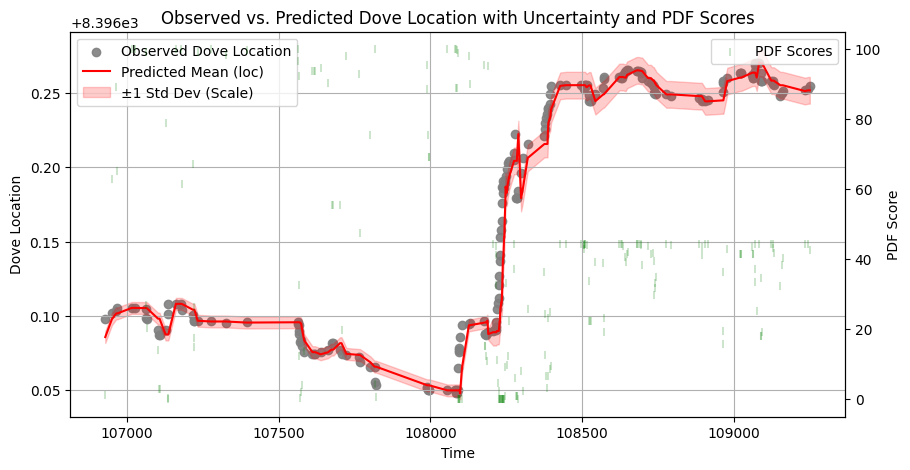

In [30]:
start_ind=1000
window_size=200
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)

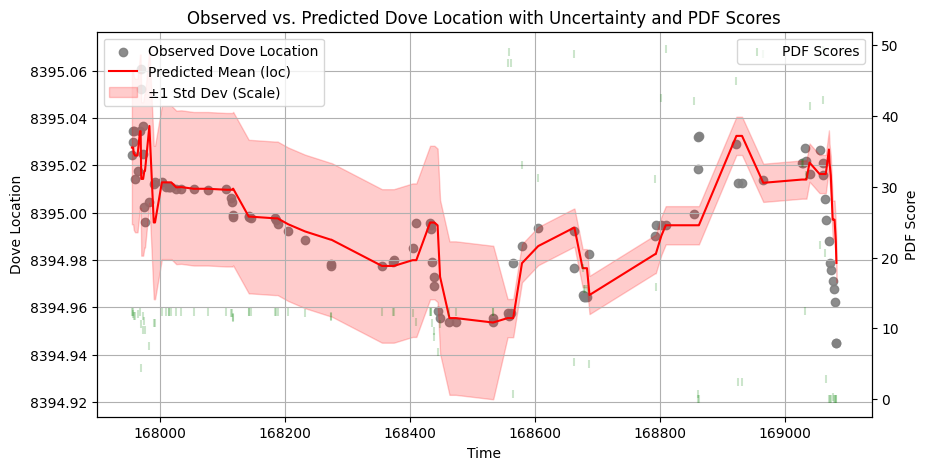

In [31]:
start_ind=8000
window_size=100
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)